In [4]:
import boto3
import pandas as pd

# 1. Configuración de la conexión
# Si tienes tus credenciales configuradas en el AWS CLI, esto funcionará automáticamente.
dynamodb = boto3.resource('dynamodb', region_name='us-east-1') # Cambia la región si es necesario
table = dynamodb.Table('stock_prices')

def get_all_stock_data(dynamo_table):
    """
    Escanea la tabla completa manejando la paginación de DynamoDB.
    """
    items = []
    response = dynamo_table.scan()
    items.extend(response.get('Items', []))

    # DynamoDB tiene un límite de 1MB por respuesta, por lo que usamos paginación
    while 'LastEvaluatedKey' in response:
        response = dynamo_table.scan(ExclusiveStartKey=response['LastEvaluatedKey'])
        items.extend(response.get('Items', []))
    
    return items

# 2. Descargar los datos
print("Descargando datos de DynamoDB...")
raw_data = get_all_stock_data(table)

# 3. Convertir a DataFrame de Pandas
df = pd.DataFrame(raw_data)

# 4. Visualización rápida
print(f"Total de registros recuperados: {len(df)}")
df.sample(20)

Descargando datos de DynamoDB...
Total de registros recuperados: 24825


,low,date,ticker,open,volume,high,close
22703,5.925480745029495,2023-09-21,CRESY,6.074054391352789,112900,6.152711346324231,6.030356407165527
23373,2.3033268397145323,2019-10-22,CEPU,2.4205872030558546,351900,2.4624658329302345,2.32845401763916
2928,7.486435101252682,2024-01-24,IRS,7.627689308580867,100600,7.724800786803554,7.55706262588501
9515,1570.239990234375,2023-12-05,MELI,1582.75,543500,1595.4100341796875,1584.5999755859375
21943,2.4135210514068604,2020-09-14,CRESY,2.4214343989172304,74402,2.476826674595859,2.4135210514068604
19296,13.894983999327462,2023-05-03,BMA,14.171744208140476,160500,14.253144543541174,14.000804901123047
8200,74.3499984741211,2025-04-15,PAM,78.04000091552734,250500,78.04000091552734,75.22000122070312
23815,1.9076480337484518,2021-07-26,CEPU,1.9680712159693499,512800,2.0630221366882324,2.0630221366882324
14365,2.849187135696411,2023-06-22,SUPV,3.1223968259823196,1257200,3.1419117872429783,2.849187135696411
1443,19.200000762939453,2024-09-26,TGS,20.65999984741211,462600,20.65999984741211,19.280000686645508


Datos: 252 filas × 8 tickers
Frontera: 100 puntos calculados


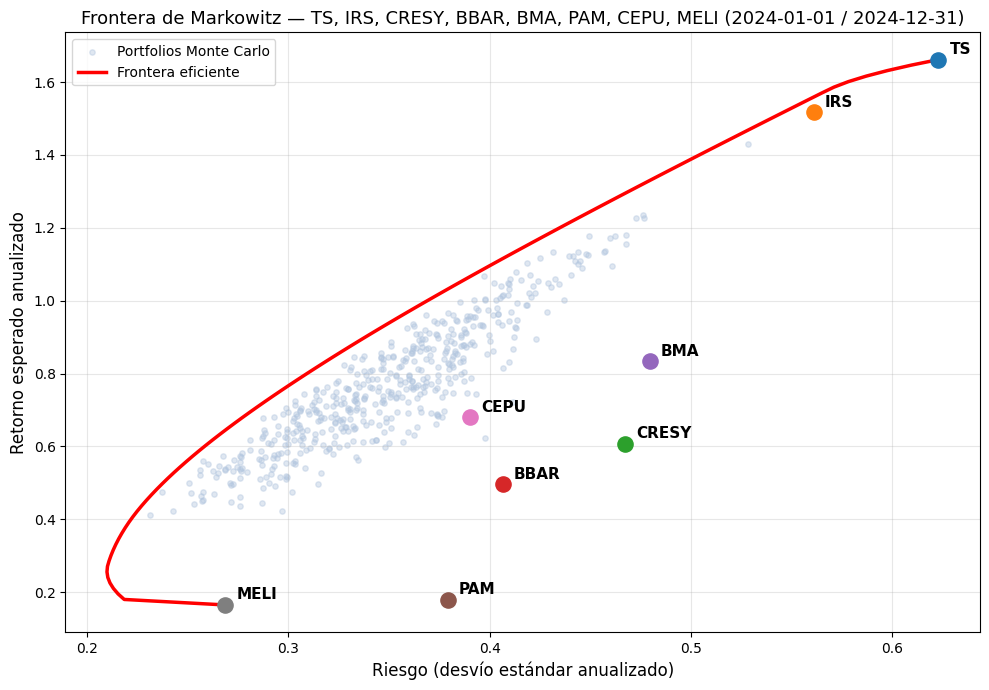

Gráfico guardado en frontier_test.png


In [6]:
import boto3
import pandas as pd
import numpy as np
from boto3.dynamodb.conditions import Key
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# ── Config ────────────────────────────────────────────────────────────────────
TICKERS    = ["TS", "IRS", "CRESY", "BBAR", "BMA", "PAM", "CEPU", "MELI"]
START_DATE = "2024-01-01"
END_DATE   = "2024-12-31"
N_POINTS   = 100       # puntos en la frontera
N_MC       = 500       # portfolios Monte Carlo de fondo

# ── 1. Bajar datos de DynamoDB ────────────────────────────────────────────────
dynamodb = boto3.resource("dynamodb", region_name="us-east-1")
table    = dynamodb.Table("stock_prices")

all_data = []
for ticker in TICKERS:
    response = table.query(
        KeyConditionExpression=Key("ticker").eq(ticker) & Key("date").between(START_DATE, END_DATE)
    )
    items = response.get("Items", [])
    while "LastEvaluatedKey" in response:
        response = table.query(
            KeyConditionExpression=Key("ticker").eq(ticker) & Key("date").between(START_DATE, END_DATE),
            ExclusiveStartKey=response["LastEvaluatedKey"]
        )
        items.extend(response.get("Items", []))
    all_data.extend(items)

raw_df = pd.DataFrame(all_data)
raw_df["close"] = raw_df["close"].astype(float)
df = raw_df.pivot(index="date", columns="ticker", values="close").dropna()
print(f"Datos: {len(df)} filas × {len(df.columns)} tickers")

# ── 2. Retornos y parámetros ──────────────────────────────────────────────────
daily_returns = df.pct_change().dropna()
mu  = daily_returns.mean().values * 252          # retorno anualizado
cov = daily_returns.cov().values * 252           # covarianza anualizada
n   = len(TICKERS)

# ── 3. Monte Carlo (fondo) ────────────────────────────────────────────────────
mc_risks, mc_returns = [], []
for _ in range(N_MC):
    w = np.random.dirichlet(np.ones(n))
    mc_returns.append(w @ mu)
    mc_risks.append(np.sqrt(w @ cov @ w))

# ── 4. Frontera eficiente por optimización cuadrática ─────────────────────────
def portfolio_variance(w):
    return w @ cov @ w          # minimizamos varianza (= std²)

constraints = [
    {"type": "eq", "fun": lambda w: np.sum(w) - 1},           # pesos suman 1
]
bounds = [(0, 1)] * n                                          # long-only

target_returns = np.linspace(min(mu), max(mu), N_POINTS)
frontier_risks, frontier_returns = [], []

for target in target_returns:
    constraints_with_return = constraints + [
        {"type": "eq", "fun": lambda w, t=target: w @ mu - t}  # retorno objetivo
    ]
    w0 = np.ones(n) / n    # punto inicial: pesos iguales
    result = minimize(
        portfolio_variance,
        w0,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints_with_return,
        options={"ftol": 1e-12, "maxiter": 1000}
    )
    if result.success:
        frontier_risks.append(np.sqrt(result.fun))
        frontier_returns.append(target)

print(f"Frontera: {len(frontier_risks)} puntos calculados")

# ── 5. Activos individuales ───────────────────────────────────────────────────
asset_risks   = [np.sqrt(cov[i, i]) for i in range(n)]
asset_returns = list(mu)

# ── 6. Plot ───────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(mc_risks, mc_returns, c="lightsteelblue", alpha=0.4, s=15, label="Portfolios Monte Carlo")
ax.plot(frontier_risks, frontier_returns, "r-", linewidth=2.5, label="Frontera eficiente")
for i, ticker in enumerate(TICKERS):
    ax.scatter(asset_risks[i], asset_returns[i], s=120, zorder=5)
    ax.annotate(ticker, (asset_risks[i], asset_returns[i]),
                textcoords="offset points", xytext=(8, 4), fontsize=11, fontweight="bold")

ax.set_xlabel("Riesgo (desvío estándar anualizado)", fontsize=12)
ax.set_ylabel("Retorno esperado anualizado", fontsize=12)
ax.set_title(f"Frontera de Markowitz — {', '.join(TICKERS)} ({START_DATE} / {END_DATE})", fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("frontier_test.png", dpi=150)
plt.show()
print("Gráfico guardado en frontier_test.png")


## Probando con C++

In [ ]:
import boto3
import pandas as pd
import numpy as np
import subprocess
import os
import matplotlib.pyplot as plt
from boto3.dynamodb.conditions import Key

# ── Config ────────────────────────────────────────────────────────────────────
TICKERS    = ["GGAL", "YPF", "MELI"]
START_DATE = "2024-01-01"
END_DATE   = "2024-12-31"
N_POINTS   = 200      # puntos en la frontera
N_MC       = 1000     # portfolios Monte Carlo de fondo

SOLVER_SRC = "/home/luke/Desktop/repositorios/markowitz_project/backend/portfolio_solver.cpp"                                          
SOLVER_BIN = "/home/luke/Desktop/repositorios/markowitz_project/backend/portfolio_solver"

# ── 0. Compilar solver si hace falta ─────────────────────────────────────────
if not os.path.exists(SOLVER_BIN) or \
   os.path.getmtime(SOLVER_SRC) > os.path.getmtime(SOLVER_BIN):
    print("Compilando portfolio_solver.cpp ...")
    result = subprocess.run(
        ["g++", "-O2", "-o", SOLVER_BIN, SOLVER_SRC],
        capture_output=True, text=True
    )
    if result.returncode != 0:
        raise RuntimeError(f"Error de compilación:\n{result.stderr}")
    print("Compilado OK")

# ── 1. Bajar datos de DynamoDB ────────────────────────────────────────────────
dynamodb = boto3.resource("dynamodb", region_name="us-east-1")
table    = dynamodb.Table("stock_prices")

all_data = []
for ticker in TICKERS:
    response = table.query(
        KeyConditionExpression=Key("ticker").eq(ticker) & Key("date").between(START_DATE, END_DATE)
    )
    items = response.get("Items", [])
    while "LastEvaluatedKey" in response:
        response = table.query(
            KeyConditionExpression=Key("ticker").eq(ticker) & Key("date").between(START_DATE, END_DATE),
            ExclusiveStartKey=response["LastEvaluatedKey"]
        )
        items.extend(response.get("Items", []))
    all_data.extend(items)

raw_df = pd.DataFrame(all_data)
raw_df["close"] = raw_df["close"].astype(float)
df = raw_df.pivot(index="date", columns="ticker", values="close").dropna()
print(f"Datos: {len(df)} filas × {len(df.columns)} tickers")

# ── 2. Parámetros anualizados ─────────────────────────────────────────────────
daily_returns = df.pct_change().dropna()
mu  = daily_returns.mean().values * 252
cov = daily_returns.cov().values * 252
n   = len(TICKERS)

# ── 3. Monte Carlo ────────────────────────────────────────────────────────────
mc_risks, mc_returns = [], []
for _ in range(N_MC):
    w = np.random.dirichlet(np.ones(n))
    mc_returns.append(float(w @ mu))
    mc_risks.append(float(np.sqrt(w @ cov @ w)))

# ── 4. Frontera eficiente vía binario C++ ─────────────────────────────────────
target_returns = np.linspace(mu.min(), mu.max(), N_POINTS)

# Construir input para el solver
lines = [str(n)]
lines.append(" ".join(f"{x:.10f}" for x in mu))
for row in cov:
    lines.append(" ".join(f"{x:.10f}" for x in row))
lines.append(str(N_POINTS))
lines.append(" ".join(f"{x:.10f}" for x in target_returns))
solver_input = "\n".join(lines)

result = subprocess.run(
    [SOLVER_BIN],
    input=solver_input,
    capture_output=True, text=True
)
if result.returncode != 0:
    raise RuntimeError(f"Error del solver:\n{result.stderr}")

frontier_risks, frontier_returns = [], []
for line in result.stdout.strip().split("\n"):
    if line.strip():
        risk, ret = map(float, line.split())
        frontier_risks.append(risk)
        frontier_returns.append(ret)

print(f"Frontera: {len(frontier_risks)} puntos")

# ── 5. Activos individuales ───────────────────────────────────────────────────
asset_risks   = [float(np.sqrt(cov[i, i])) for i in range(n)]
asset_returns = list(mu)

# ── 6. Plot ───────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(mc_risks, mc_returns, c="lightsteelblue", alpha=0.3, s=12, label="Monte Carlo")
ax.plot(frontier_risks, frontier_returns, "r-", linewidth=2.5, label="Frontera eficiente (C++)")
for i, ticker in enumerate(TICKERS):
    ax.scatter(asset_risks[i], asset_returns[i], s=120, zorder=5)
    ax.annotate(ticker, (asset_risks[i], asset_returns[i]),
                textcoords="offset points", xytext=(8, 4), fontsize=11, fontweight="bold")

ax.set_xlabel("Riesgo (desvío estándar anualizado)", fontsize=12)
ax.set_ylabel("Retorno esperado anualizado", fontsize=12)
ax.set_title(f"Frontera de Markowitz — {', '.join(TICKERS)}  ({START_DATE} / {END_DATE})", fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("frontier_test.png", dpi=150)
plt.show()
print("Gráfico guardado en frontier_test.png")


NameError: name '__file__' is not defined